In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Load data
df = pd.read_csv('../data/raw/train.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5634 non-null   object 
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   int64  
 3   Partner           5634 non-null   object 
 4   Dependents        5634 non-null   object 
 5   tenure            5634 non-null   int64  
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  5634 non-null   object 


In [3]:
# Check quantity of rows and columns
print('Quantidade de Linhas: ', df.shape[0])
print('Quantidade de Colunas: ', df.shape[1])

Quantidade de Linhas:  5634
Quantidade de Colunas:  21


In [4]:
# Check null values
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

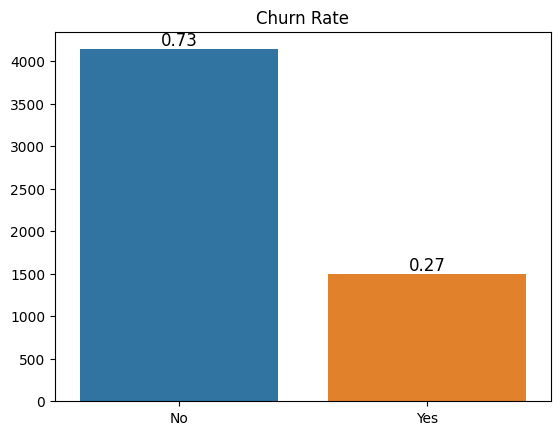

In [10]:
# Plot target variable
#plt.figure(figsize=(4,3))
ax = sns.barplot(x=df['Churn'].value_counts().index, 
                 y=df['Churn'].value_counts().values,
                 data=df)

total = float(len(df))

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height, '{:1.2f}'.format(height/total), 
            fontsize=12, color='black', ha='center', va='bottom')

plt.title('Churn Rate')
plt.show()

In [11]:
# Select only categorical variables
df_cat = df.select_dtypes(include=['object'])

In [14]:
df_cat.head()

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
0,4223-BKEOR,Female,No,Yes,Yes,No,DSL,Yes,No,Yes,No,No,Yes,One year,No,Mailed check,1336.8,No
1,6035-RIIOM,Female,No,No,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),5129.45,No
2,3797-VTIDR,Male,Yes,No,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,23.45,Yes
3,2568-BRGYX,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,237.95,Yes
4,2775-SEFEE,Male,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),,No
